In [20]:
import dynamiqs as dq
import jax as jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

|██████████| 100.0% ◆ elapsed 21.13ms ◆ remaining 0.00ms
100%|██████████| 50/50 [00:01<00:00, 28.38it/s]


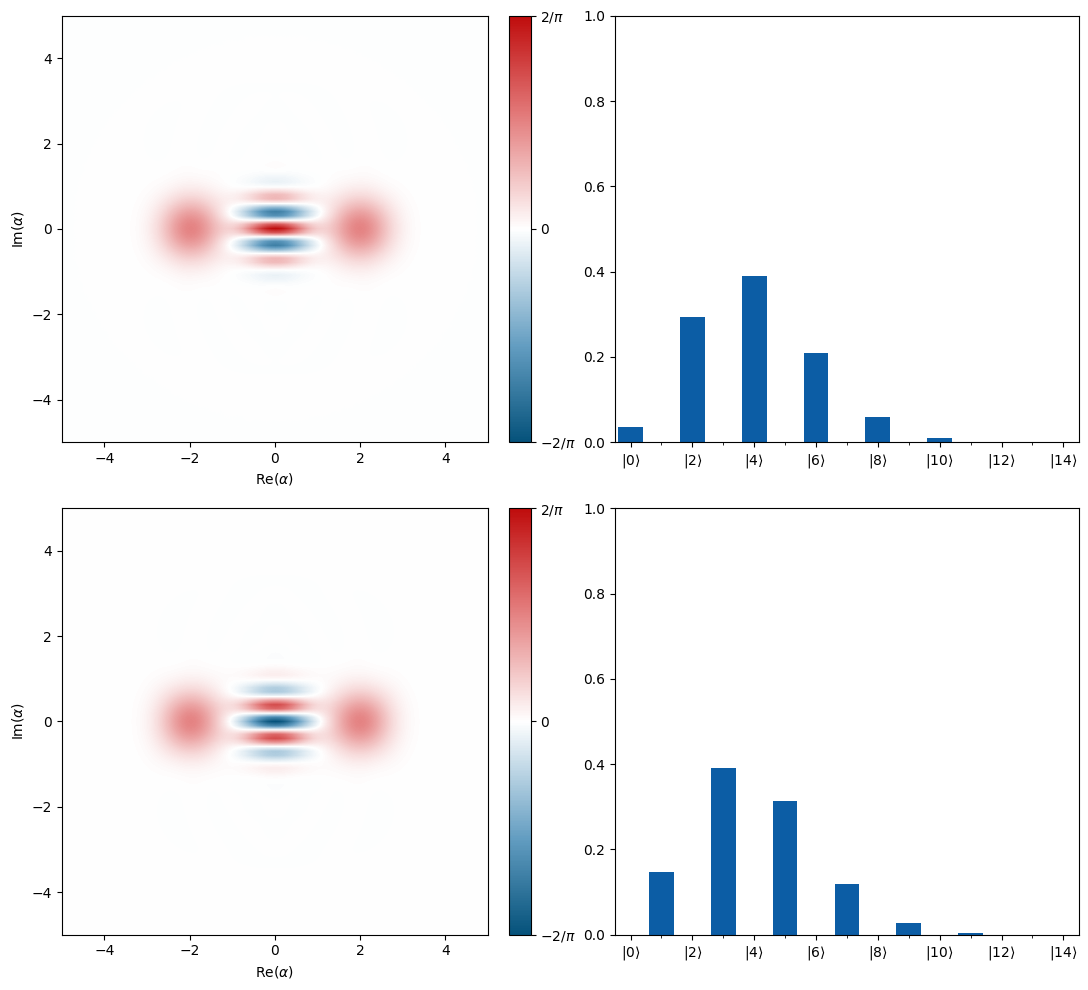

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import dynamiqs as dq  # assuming dynamiqs is imported as dq

# --- Parameters and initial setup ---
alpha = 2.0             # Cat size
na = 15                 # Hilbert space dimension
a = dq.destroy(na)      # Annihilation operator
psi0 = dq.fock(na, 0)   # Initial state (vacuum)
H = dq.zeros(na)        # Zero Hamiltonian (no unitary evolution)
kappa_2 = 1             # 2 photon loss rate

# Create even and odd cat states (for later mosaic plots)
cat_even = dq.unit(dq.coherent(na, alpha) + dq.coherent(na, -alpha))
cat_odd  = dq.unit(dq.coherent(na, alpha) - dq.coherent(na, -alpha))

# --- Time evolution setup ---
t_save = np.linspace(0, 3, 100)
# Define the two-photon loss operator (using matrix multiplication '@')
loss_op = np.sqrt(kappa_2) * (a @ a - alpha**2 * dq.eye(na))
res = dq.mesolve(H, [loss_op], psi0, t_save)

# --- Create and save the Wigner function animation as a GIF ---
# Generate the animation without xlim and ylim arguments.
wigner_anim = dq.plot.wigner_gif(res.states)
# Save the animation as a GIF file (using the pillow writer and desired fps)
# wigner_anim.save('wigner_animation.gif', writer='pillow', fps=10)

# --- Optional: Create the mosaic plots for the cat states ---
fig, ax = plt.subplots(2, 2, figsize=(11, 10))
dq.plot.wigner(cat_even, ax=ax[0, 0])  # Wigner of even cat state
dq.plot.fock(cat_even, ax=ax[0, 1])    # Fock representation of even cat state
dq.plot.wigner(cat_odd, ax=ax[1, 0])     # Wigner of odd cat state
dq.plot.fock(cat_odd, ax=ax[1, 1])       # Fock representation of odd cat state
plt.tight_layout()
plt.show()


In [32]:
import numpy as np
import dynamiqs as dq  # Replace or adjust according to your quantum module (e.g., qutip)
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from IPython.display import HTML

# ---------------------------
# 1. Run the Simulation
# ---------------------------
alpha = 2.0             # Cat size
na = 15                 # Hilbert space dimension
a = dq.destroy(na)      # Annihilation operator
psi0 = dq.fock(na, 0)   # Initial state
H = dq.zeros(na)        # Zero Hamiltonian
kappa_2 = 1             # 2 photon loss rate

# Time array for simulation
t_save = np.linspace(0, 4, 100)

# Define the loss operator
loss_op = np.sqrt(kappa_2) * (a @ a - alpha**2 * dq.eye(na))

# Run the simulation
res = dq.mesolve(H, [loss_op], psi0, t_save)

# ---------------------------
# 2. Set Up the Figure
# ---------------------------
fig, ax = plt.subplots(2, 2, figsize=(11, 10))

# ---------------------------
# 3. Define the Update Function
# ---------------------------
def update(frame):
    # Clear all subplots
    for a_axis in ax.flatten():
        a_axis.cla()
    
    # Get the quantum state for the current frame
    current_state = res.states[frame]
    
    # Plot Wigner and Fock representations
    dq.plot.wigner(current_state, ax=ax[0, 0])
    dq.plot.fock(current_state, ax=ax[0, 1])
    
    # For demonstration, re-use the same state on the bottom row.
    dq.plot.wigner(current_state, ax=ax[1, 0])
    dq.plot.fock(current_state, ax=ax[1, 1])
    
    # Update the title with the current time
    fig.suptitle(f'Time = {t_save[frame]:.2f}', fontsize=16)

# ---------------------------
# 4. Create the Animation
# ---------------------------
ani = animation.FuncAnimation(fig, update, frames=len(t_save), repeat=False)

# ---------------------------
# 5. Save the Animation as a GIF
# ---------------------------
filename = 'quantum_animation.gif'
ani.save(filename, writer=PillowWriter(fps=20))

# ---------------------------
# 6. (Optional) Display the GIF in Jupyter Notebook
# ---------------------------
plt.close(fig)
HTML(f'<img src="{filename}">')

|██████████| 100.0% ◆ elapsed 33.60ms ◆ remaining 0.00ms


|██████████| 100.0% ◆ elapsed 240.00ms ◆ remaining 0.00ms  


/opt/anaconda3/envs/qc/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/qc/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


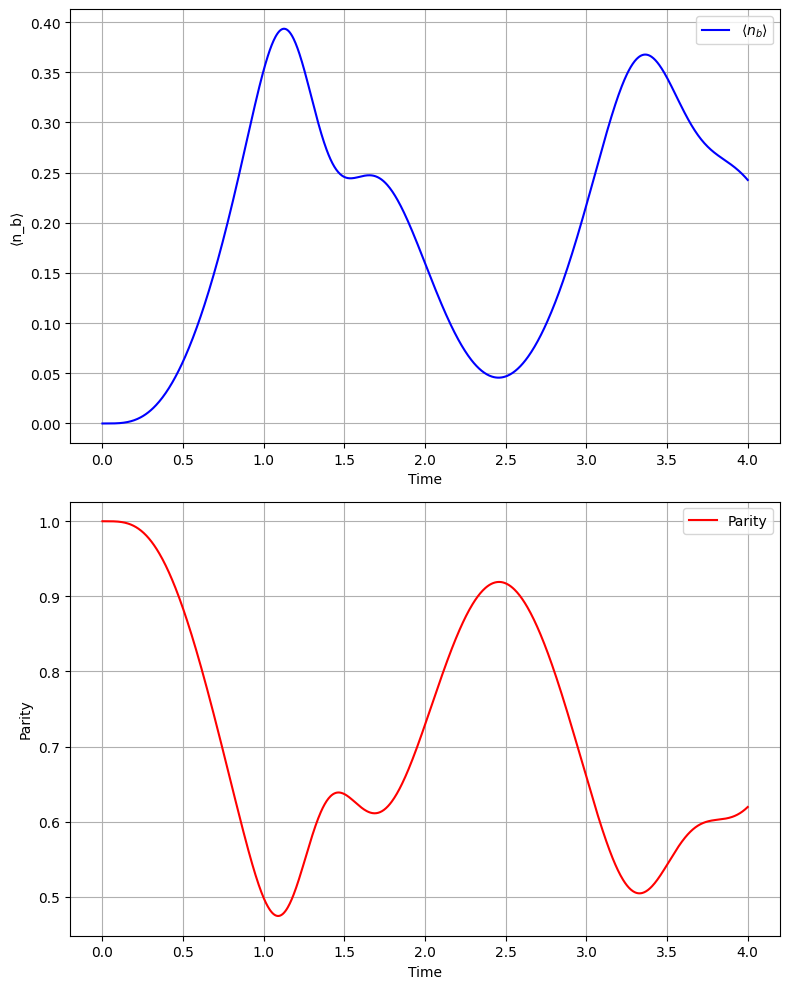

In [ ]:
import dynamiqs as dq
import jax.numpy as jnp       
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from IPython.display import HTML, display
from functools import reduce     # Import reduce to sum qarrays without starting with 0

# Hilbert-space truncations
na = 20   # Buffer mode a 
nb = 5    # Memory mode b

# Operators in the composite Hilbert space
a = dq.tensor(dq.destroy(na), dq.eye(nb))     # Mode a annihilation operator
adag = a.dag()                                # Mode a creation operator
b = dq.tensor(dq.eye(na), dq.destroy(nb))     # Mode b annihilation operator
bdag = b.dag()                                # Mode b creation operator

# Other parameters
g_2 = 1.0
eps_d = -4.0
kappa_b = 10

# Hamiltonian construction
H_2ph = g_2 * (adag @ adag @ b) + jnp.conjugate(g_2) * (a @ a @ bdag)
H_d = jnp.conjugate(eps_d) * b + eps_d * bdag
H = eps_d * (a + adag) + g_2 * (adag @ b + a @ bdag)

# Initalizes both modees in the vacuum state
psi0 = dq.tensor(dq.fock(na, 0), dq.fock(nb, 0))

# Creates time array
T = 4
t_save = jnp.linspace(0, T, 500) 

# Collapse operator on b
c_ops = [jnp.sqrt(kappa_b) * b]

# Solves the Linblad master equation
res = dq.mesolve(H, c_ops, psi0, t_save)

# Expectation value of n_b
n_b = bdag @ b

# Build the parity operator for mode b.
# Instead of using a diagonal function, sum over the Fock state projectors weighted by (-1)^n.
# It is assumed that dq.fock_dm(nb, n) creates the projector |n><n| for mode b.
terms = [ (-1)**n * dq.fock_dm(nb, n) for n in range(nb) ]
parity_b_local = reduce(lambda a, b: a + b, terms)
# Now, tensor with the identity for mode a.
parity_b = dq.tensor(dq.eye(na), parity_b_local)

# Compute expectation values for each time step.
n_b_expect = [dq.expect(n_b, state) for state in res.states]
parity_b_expect = [dq.expect(parity_b, state) for state in res.states]

# ---------------------------
# 6. Animate the Wigner function of mode a
# ---------------------------
fig_w, ax_w = plt.subplots(1, 1, figsize=(6, 6))

def update(frame):
    ax_w.cla()  # Clear the axis.
    # Obtain the reduced state of mode a by tracing out mode b.
    rho_a = dq.unit(res.states[frame])
    dq.plot.wigner(rho_a, ax=ax_w)
    ax_w.set_title(f"Mode a Wigner Function\nTime = {t_save[frame]:.2f}")

ani = animation.FuncAnimation(fig_w, update, frames=len(t_save), repeat=False)
gif_filename = 'wigner_mode_a.gif'
ani.save(gif_filename, writer=PillowWriter(fps=25))
plt.close(fig_w)
display(HTML(f'<img src="{gif_filename}">'))

# ---------------------------
# 7. Plot the expectation value and parity for mode b
# ---------------------------
fig2, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot the expectation value of the photon number in mode b.
ax1.plot(t_save, n_b_expect, label=r'$\langle n_b \rangle$', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('⟨n_b⟩')
ax1.legend()
ax1.grid(True)

# Plot the photon number parity in mode b.
ax2.plot(t_save, parity_b_expect, label='Parity', color='red')
ax2.set_xlabel('Time')
ax2.set_ylabel('Parity')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()